# Machine Learning Coursework 2

For coursework 2 you will be asked to train and evalute several different classifiers: Naïve Bayes classifier, Random Forest classifier, and kNN classifier using the iris dataset. You will be asked to answer a series of questions relating to each individual model and questions comparing each model. 

#### You are free to use the sklearn library. 


Notes:
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking 

The grades in this coursework are allocated approximately as follows:

|                                                    | mark  |  
|----------------------------------------------------|-------|
| Code                                               | 7     |
| Code Report/comments                               | 6     |
| Model questions                                    | 14    |  
| Model comparision questions                        | 18    |
| Total available                                    |**45** |  

##### Remember to save your notebook as “CW2.ipynb”. It is a good idea to re-run the whole thing before saving and submitting. 










## Web References

- [The Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
- [sklearn.datasets.load_iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)
- [Iris Species:100% Accuracy using Naive bayes](https://www.kaggle.com/vinayshaw/iris-species-100-accuracy-using-naive-bayes)
- [Naive Bayes Classifier with Scikit](https://python-course.eu/machine-learning/naive-bayes-classifier-with-scikit.php)
- [scikit-learn Classifiers on Iris Dataset](https://www.kaggle.com/chungyehwang/scikit-learn-classifiers-on-iris-dataset)

## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
random_state = 1337

## 1. Classifiers [7 marks total]
Code and train your three classifiers in the cells below the corresponding header. You do not need to implement cross-validation in this coursework, simply fit the data. You are free to use sklearn and other packages where necessary.  



In [3]:
# import datasets
from sklearn import datasets 

# load data
iris = datasets.load_iris() # load data 
#print(iris.DESCR) # print dataset description

In [4]:
# get the predictors and target
X = iris.data
y = iris.target

In [5]:
# split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
print('There are %d samples in the training set and %d samples in the test set' % (X_train.shape[0], X_test.shape[0]))

There are 105 samples in the training set and 45 samples in the test set


### ℹ️ Baseline

The Pycaret library is use in this section to establish a baseline for model performance.

In [6]:
# import the pycaret dependencies
from pycaret.classification import *

In [7]:
# convert the training dataset to a dataframe
df_train = pd.DataFrame(data=X_train, columns=iris.feature_names)
df_train['target'] = pd.Series(y_train)

# convert the test data to a dataframe
df_test = pd.DataFrame(data=X_test, columns=iris.feature_names)
df_test['target'] = pd.Series(y_test)

In [8]:
# initialize the training environment and transformation pipeline
classifier = setup(
    data=df_train, 
    target='target',
    session_id=random_state,
    silent=True,
    verbose=False)

In [9]:
# train a naive bayes, random forest, and knn classification model
models = compare_models(include=['nb', 'rf', 'knn'], n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9857,1.0000,0.9833,0.9905,0.9848,0.9781,0.9807,1.1090
knn,K Neighbors Classifier,0.9732,1.0000,0.9778,0.9811,0.9729,0.9597,0.9642,0.0230
nb,Naive Bayes,0.9589,0.9950,0.9611,0.9716,0.9576,0.9379,0.9449,3.5360


The following section optimizes each model by using a [random grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) from the scikit-learn library.

In [10]:
# find the best hyperparameters for each model
tuned_models = [tune_model(model,search_library='scikit-learn', search_algorithm='random') for model in models]

# display the model parameters
for model in models:
    print(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8571,1.0000,0.8889,0.9048,0.8571,0.7879,0.8125
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.8571,1.0000,0.8333,0.9048,0.8476,0.7812,0.8069
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1337, verbose=0,
                       warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
GaussianNB(priors=None, var_smoothing=1e-09)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


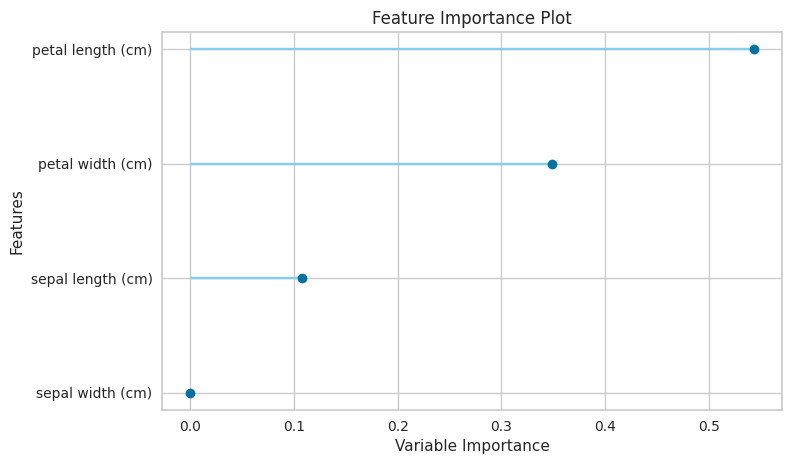

In [11]:
# show the feature importance of the random forest model
plot_model(tuned_models[0], plot='feature')

In [12]:
# evaluate each model on the test data
for model in tuned_models:
    print('--- %s ---' % type(model))

    df_predicted = predict_model(estimator=model, data=df_test)
    print(classification_report(y_true=df_predicted.target, y_pred=df_predicted.Label))

--- <class 'sklearn.ensemble._forest.RandomForestClassifier'> ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      1.00      0.95         9
           2       1.00      0.94      0.97        16

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.97        45
weighted avg       0.98      0.98      0.98        45

--- <class 'sklearn.neighbors._classification.KNeighborsClassifier'> ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      1.00      0.95         9
           2       1.00      0.94      0.97        16

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.97        45
weighted avg       0.98      0.98      0.98        45

--- <class 'sklearn.naive_bayes.GaussianNB'> ---
              precision    recall  f1-score   supp

### 1.1 Naïve Bayes Classifier [2]
Train a naïve bayes classifier in python. 

Use your code to fit the data given above. 


In [13]:
#Write your code here

# train naive bayes classifier on iris dataset


### 1.2 Random Forst Classifier [3]
Train a random forest classifier in python. Use your code to fit the data given above. 

Evaluate feature performance of the model. 

Visualise the feature importance. 


In [14]:
#Write your code here

### 1.3 kNN Classifier [2]
Train a kNN classifier in python. 

Use your code to fit the data given above. 

In [15]:
#Write your code here

## 2 Code Report [6 marks total]
In a markdown box, write a short report (no more than 500 words) that describes the workings of your code. 

In [16]:
#Write your answer here

## 3 Model Questions [14 marks total]
Please answer the following questions relating to your classifiers. 

### 3.1 Naïves Bayes Questions [4]
Why do zero probabilities in our Naïve Bayes model cause problems? 

How can we avoid the problem of zero probabilities in our Naïve Bayes model? 

Please answer in the cell below.

In [17]:
#Write your answer here

# https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html#:~:text=The%20zero%2Dfrequency%20problem,all%20the%20probabilities%20are%20multiplied.

### 3.2 Random Forest Questions [6]
Which feature is the most important from your random forest classifier? 

Can any features be removed to increase accuracy of the model, if so which features? 

Explain why it would be useful to remove these features. 

Please answer in the cell below.

In [18]:
#Write your answer here

### 3.3 kNN Questions [4]
Do you think the kNN classifier is best suited to the iris dataset? 

What ideal qualities would the most appropriate dataset display?  

Please answer in the cell below.

In [19]:
#Write your answer here

## 4 Comparing Models [18 marks total]
Please answer the following questions comparing your classifiers.

### 4.1 Compare each model [3]
What differences do you see between your Naïve Bayes classifier, your random forest classifier, and your kNN classifier? 

In [20]:
#Write your answer here

### 4.2 Accuracy [6]
Can you explain why there are differences in accuracy between the three classifiers? 

In [21]:
#Write your answer here

### 4.3 Appropriate Use [9]
When would it be appropriate to use each different classifier? 

Reference real-world situations and examples of specific data sets and explain why that classifier would be most appropriate for that use-case.

In [22]:
#Write your answer here